In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal as mvn

2023-06-27 16:32:57.224802: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 16:32:57.329172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 16:32:57.794123: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 16:32:57.797808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 16:32:59.911654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# model_alogp =  tf.keras.models.load_model("..//Base_Models//Model_BOTH")

In [3]:
# read small mol phase 3 features
small_mol_phase_3_features = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_features.csv")

In [4]:
small_mol_phase_3_outputs = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")

In [5]:
# small_mol_phase_3_outputs

In [6]:
# small_mol_phase_3_preds = model_alogp.predict([small_mol_phase_3_features["Smiles"].values, small_mol_phase_3_features.iloc[:,1:].values], batch_size = 1000)

In [7]:
bottleneck_features_smiles = np.load("..//Data//small_mol_phase_3_features_using_Smiles.npy")

In [8]:
# bottleneck_features.shape

In [9]:
bottleneck_features_rdkit = np.load("..//Data//small_mol_phase_3_features_using_Rdkit.npy")

In [10]:
smiles_features = bottleneck_features_smiles
rdkit_features = bottleneck_features_rdkit

In [11]:
smiles_features.shape

(959, 32)

In [12]:
rdkit_features.shape

(959, 32)

In [13]:
# smiles_weights = model_alogp.get_weights()[-2][:32, :]
# rdkit_weights = model_alogp.get_weights()[-2][32:, :]

In [14]:
# final_bias = model_alogp.get_weights()[-1].reshape(1,-1)

In [15]:
smiles_output = np.load("..//Data//smiles_outputs.npy")

In [16]:
rdkit_output = np.load("..//Data//rdkit_outputs.npy")

In [17]:
smiles_output

array([[-0.008663  , -0.32012644],
       [ 0.3382033 , -0.31685376],
       [ 0.11221686, -1.2013034 ],
       ...,
       [-2.202789  ,  0.2556882 ],
       [ 2.5921938 , -0.50616574],
       [-0.57648194,  1.1811748 ]], dtype=float32)

In [18]:
# (smiles_output + rdkit_output)

In [19]:
# small_mol_phase_3_preds

In [20]:
# pd.read_csv("..//Data//y_train.csv")

In [21]:
y_train = pd.read_csv("..//Data//y_train.csv")
# y_train = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv").iloc[:,1:]

In [22]:
y_train.shape

(1694445, 2)

In [23]:
std_targets = pickle.load(open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
# std_targets = StandardScaler()

In [25]:
y_train = std_targets.transform(y_train)

In [26]:
R_t = np.cov(y_train.T)

In [27]:
np.corrcoef(y_train.T)

array([[ 1.       , -0.3030172],
       [-0.3030172,  1.       ]])

In [28]:
np.cov(smiles_output.T)

array([[ 2.02894228, -0.70199591],
       [-0.70199591,  1.57403392]])

In [29]:
np.cov(rdkit_output.T)

array([[ 2.00398076, -0.70407812],
       [-0.70407812,  1.57108448]])

In [30]:
np.corrcoef(smiles_output.T)

array([[ 1.        , -0.39281919],
       [-0.39281919,  1.        ]])

In [31]:
np.sqrt(((small_mol_phase_3_outputs.iloc[:,1:] - std_targets.inverse_transform(smiles_output))**2).mean(0))

AlogP                 0.138200
Polar Surface Area    2.238709
dtype: float64

In [32]:
np.sqrt(((small_mol_phase_3_outputs.iloc[:,1:] - std_targets.inverse_transform(rdkit_output))**2).mean(0))

AlogP                  0.283819
Polar Surface Area    10.808705
dtype: float64

In [33]:
R_t

array([[ 1.00000059, -0.30301738],
       [-0.30301738,  1.00000059]])

In [34]:
# tf.linalg.cholesky(R_t).numpy()@tf.linalg.cholesky(R_t).numpy().T

In [35]:
# R_t

In [36]:
var = 0.3

In [37]:
cor = -0.2

In [38]:
R_t = np.array([[var,cor*var], [cor*var, var]])

In [39]:
R_t

array([[ 0.3 , -0.06],
       [-0.06,  0.3 ]])

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
smiles_output.shape

(959, 2)

In [42]:
import random

In [43]:
def generate_data_copies(smiles_output, rdkit_output, smiles_features, rdkit_features, weight_smiles = 0.5):
    error_mean = np.zeros((smiles_output.shape[1],))
    error_cov = R_t
    
    mvn_error = mvn(error_mean, error_cov).rvs(smiles_output.shape[0])

    
    weighted_output = weight_smiles*smiles_output + (1-weight_smiles)*rdkit_output
    
    weighted_output_with_error = weighted_output + mvn_error
    
    req_list = [smiles_features, rdkit_features, weighted_output, weighted_output_with_error]

    return req_list

In [44]:
smiles_heavy_catch = generate_data_copies(smiles_output, rdkit_output, smiles_features, rdkit_features, weight_smiles = 0.70)

In [45]:
with open("..//Data//smiles_70_catch.pickle", "wb") as f: 
    pickle.dump(smiles_heavy_catch, f)

In [46]:
import matplotlib.pyplot as plt

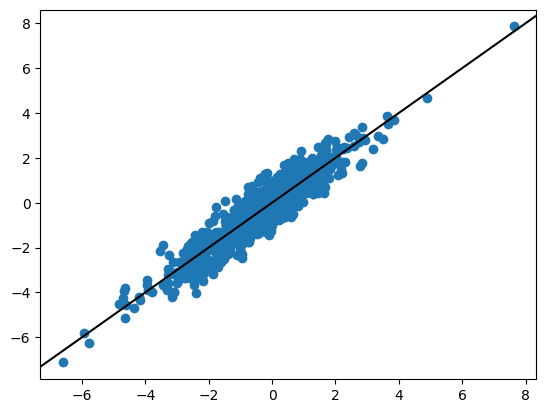

In [47]:
plt.scatter(smiles_heavy_catch[2][:,0], smiles_heavy_catch[3][:,0])
plt.axline((0,0), slope = 1, c = "black")

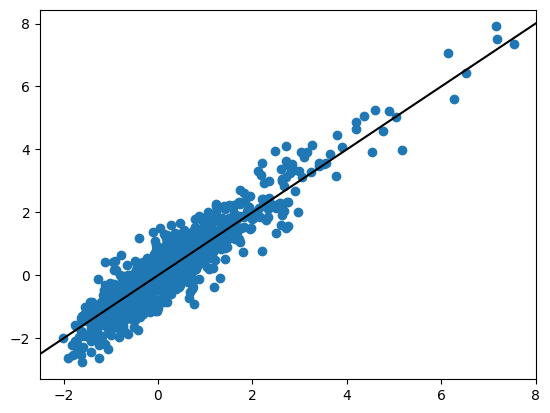

In [48]:
plt.scatter(smiles_heavy_catch[2][:,1], smiles_heavy_catch[3][:,1])
plt.axline((0,0), slope = 1, c = "black")

In [56]:
np.sqrt(((small_mol_phase_3_outputs.iloc[:,-2:] - std_targets.inverse_transform(smiles_heavy_catch[2]))**2).mean(0))

AlogP                 0.136946
Polar Surface Area    3.704044
dtype: float64

In [50]:
rdkit_heavy_catch = generate_data_copies(smiles_output, rdkit_output, smiles_features, rdkit_features, weight_smiles = 0.4)

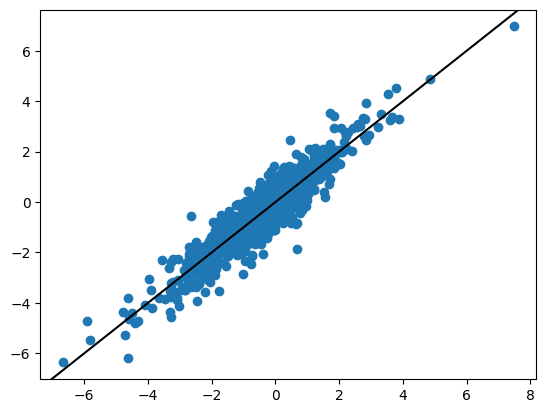

In [51]:
plt.scatter(rdkit_heavy_catch[2][:,0], rdkit_heavy_catch[3][:,0])
plt.axline((0,0), slope = 1, c = "black")

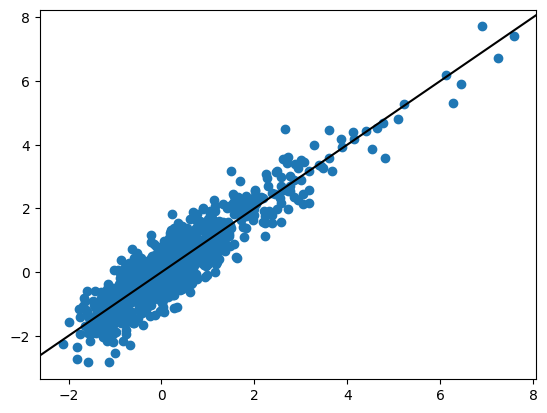

In [52]:
plt.scatter(rdkit_heavy_catch[2][:,1], rdkit_heavy_catch[3][:,1])
plt.axline((0,0), slope = 1, c = "black")

In [53]:
with open("..//Data//rdkit_60_catch.pickle", "wb") as f: 
    pickle.dump(rdkit_heavy_catch, f)

In [57]:
np.sqrt(((small_mol_phase_3_outputs.iloc[:,-2:] - std_targets.inverse_transform(rdkit_heavy_catch[2]))**2).mean(0))

AlogP                 0.185761
Polar Surface Area    6.611862
dtype: float64